
# Time Series Forecasting -LSTM & RNN


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [34]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

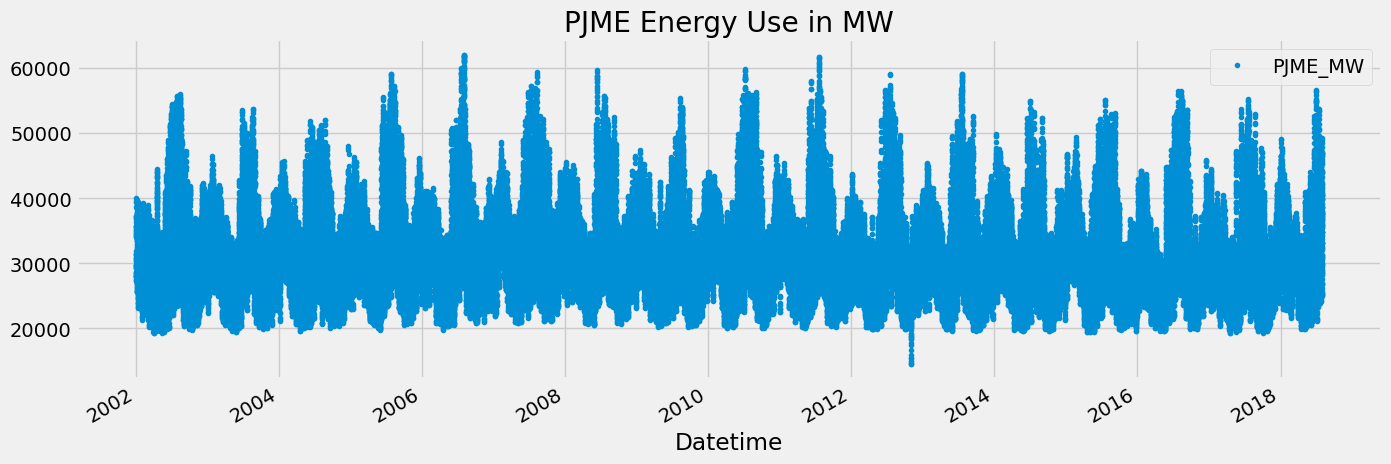

In [35]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

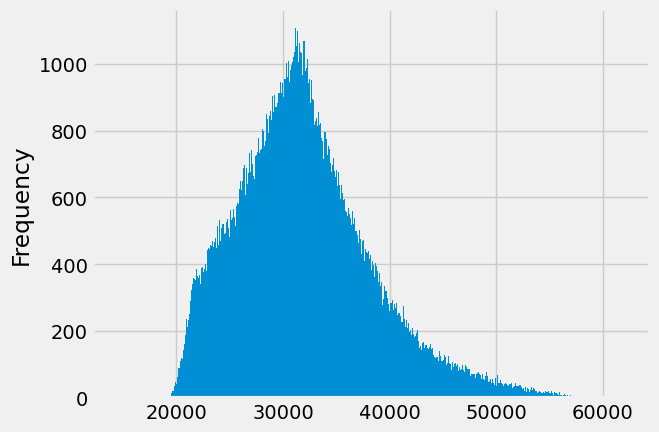

In [36]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

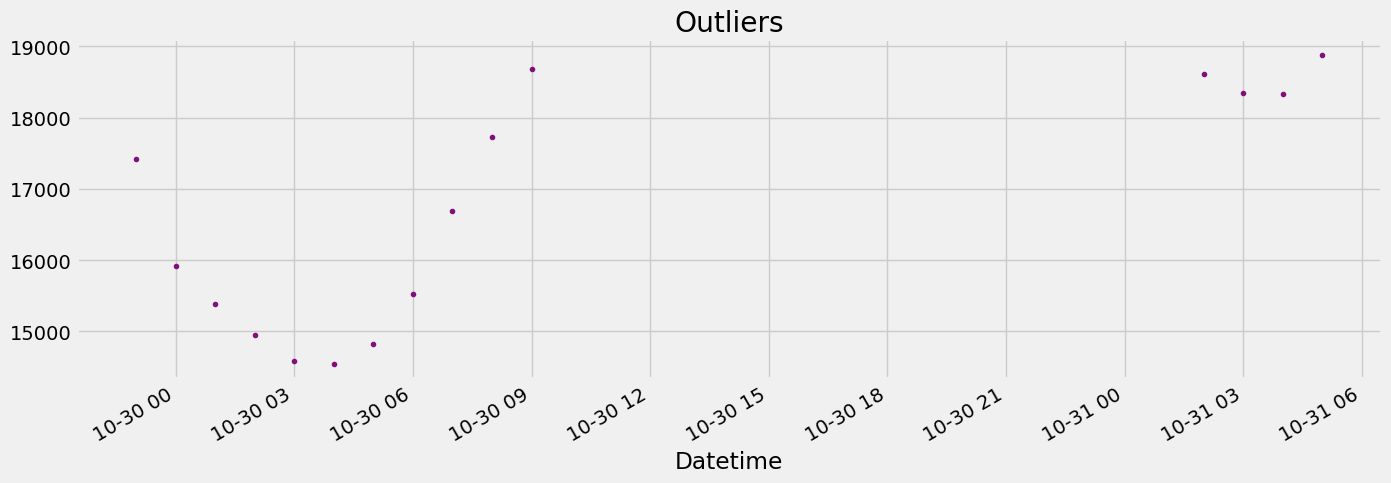

In [37]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [38]:
df = df.query('PJME_MW > 19_000').copy()

# 2. Scaling Target (Normalization Process)


In [39]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    scaler = MinMaxScaler()
    df['PJME_MW'] = scaler.fit_transform(df[['PJME_MW']])
    return df, scaler

df_norm, scaler = normalize_data(df)
df_norm.shape

(145351, 1)

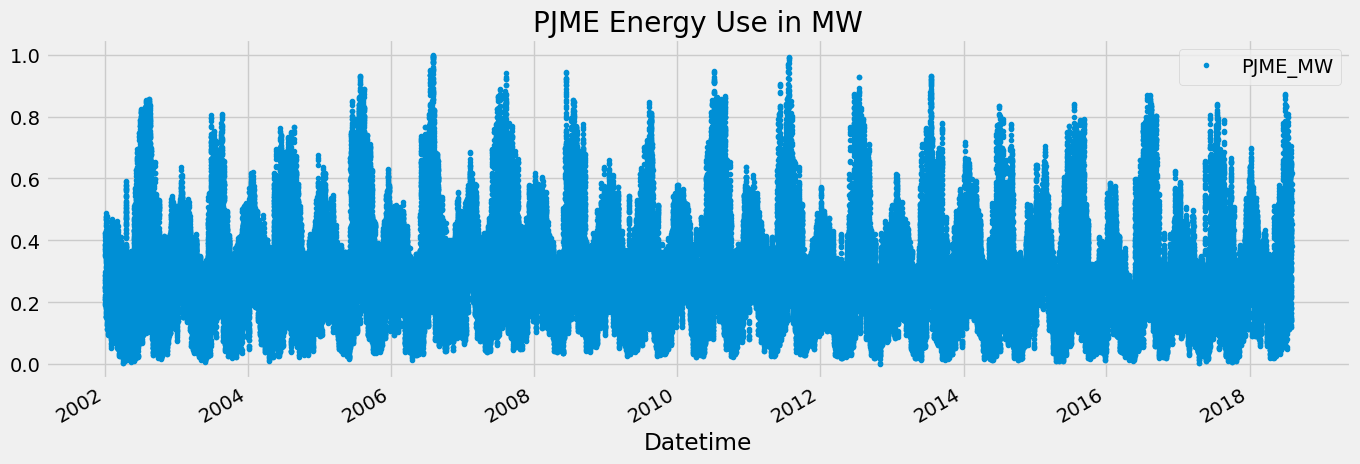

In [40]:
df_norm.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 3. Train/Test Split

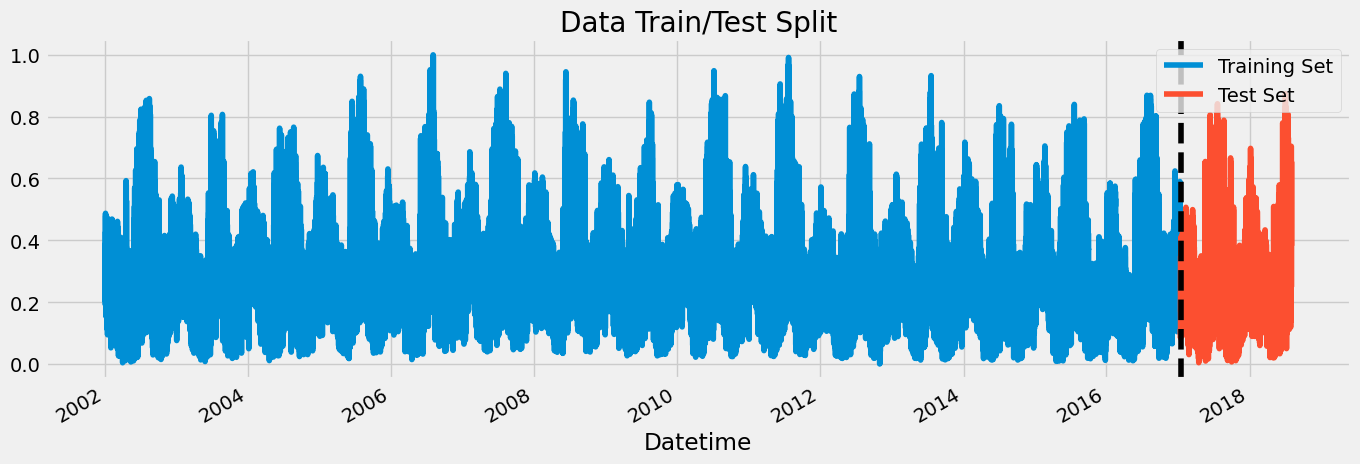

In [42]:
split_date = '2017-01-13'

pjme_train = df_norm.loc[df_norm.index <= split_date].copy()
pjme_test = df_norm.loc[df_norm.index > split_date].copy()
# Plot train and test so you can see where we have split

fig, ax = plt.subplots(figsize=(15, 5))
pjme_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
pjme_test.plot(ax=ax, label='Test Set')
ax.axvline('2017-01-13', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 4. Prepare Data for Training the RNN & LSTM

In [44]:
def load_data(data, seq_len):
    X_train, y_train = [], []
    
    # Generate training data
    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i - seq_len : i, 0].values)
        y_train.append(data.iloc[i, 0])
    
    # Split into train and test sets
    X_test, y_test = X_train[110000:], y_train[110000:]
    X_train, y_train = X_train[:110000], y_train[:110000]
    
    # Convert to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    # Reshape data for RNN/LSTM input
    X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
    X_test = X_test.reshape((X_test.shape[0], seq_len, 1))
    
    return X_train, y_train, X_test, y_test


- The 'seq_len' parameter determines how far back the model will look at historical data, helping the model to capture time dependencies in a memory-aware way.
- We should note that if "seq_len" is too large, the model can become complex and prone to overlearning.
- We can specify separate seq_len values for RNN and LSTM

In [46]:
seq_len = 20 

# Let's create train, test data
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35331, 20, 1)
y_test.shape =  (35331,)


# 5. Building RNN model


In [47]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense

def create_rnn_model(input_shape):
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(units=64, activation="tanh", return_sequences=True, input_shape=input_shape))
    rnn_model.add(Dropout(0.3))
    
    rnn_model.add(SimpleRNN(units=64, activation="tanh", return_sequences=True))
    rnn_model.add(Dropout(0.3))
    
    rnn_model.add(SimpleRNN(units=64, activation="tanh", return_sequences=False))
    rnn_model.add(Dropout(0.3))
    
    rnn_model.add(Dense(units=1))
    
    return rnn_model

# Define input shape based on X_train
input_shape = (X_train.shape[1], 1)

# Create RNN model
rnn_model = create_rnn_model(input_shape)

# Display model summary
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 64)            4224      
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 64)            8256      
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [49]:
from keras.optimizers import Adam

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile RNN model
rnn_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define hyperparameters
epochs = 15
batch_size = 1024

# Train RNN model
rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/15
97/97 [==============================] - 8s 69ms/step - loss: 0.1546 - val_loss: 0.0037
Epoch 2/15
97/97 [==============================] - 6s 66ms/step - loss: 0.0260 - val_loss: 0.0019
Epoch 3/15
97/97 [==============================] - 7s 73ms/step - loss: 0.0130 - val_loss: 0.0013
Epoch 4/15
97/97 [==============================] - 7s 71ms/step - loss: 0.0086 - val_loss: 0.0011
Epoch 5/15
97/97 [==============================] - 7s 70ms/step - loss: 0.0063 - val_loss: 9.0712e-04
Epoch 6/15
97/97 [==============================] - 7s 71ms/step - loss: 0.0051 - val_loss: 8.1404e-04
Epoch 7/15
97/97 [==============================] - 7s 68ms/step - loss: 0.0042 - val_loss: 7.6079e-04
Epoch 8/15
97/97 [==============================] - 7s 75ms/step - loss: 0.0037 - val_loss: 7.1345e-04
Epoch 9/15
97/97 [==============================] - 7s 70ms/step - loss: 0.0032 - val_loss: 6.5216e-04
Epoch 10/15
97/97 [==============================] - 7s 75ms/step - loss: 0.0029 - val_lo

In [71]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)

# Calculate R2 score
rnn_r2_score = r2_score(y_test, rnn_predictions)
print("R2 Score of RNN model =", rnn_r2_score)

# Calculate RMSE
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))
print("RMSE of RNN model =", rnn_rmse)

1105/1105 [==============================] - 2s 2ms/step
R2 Score of RNN model = 0.9768697909890376
RMSE of RNN model = 0.02260097254240386


In [57]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions).flatten()

# Ensure lengths match
y_test_inverse = y_test_inverse[:len(last_6169_index_dates)]
rnn_predictions_inverse = rnn_predictions_inverse[:len(last_6169_index_dates)]

# Create DataFrame with aligned data
results_RNN = pd.DataFrame({"Date": last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions_inverse})

# Print the DataFrame
print(results_RNN)

                    Date   Actual     Predicted
0    2017-02-13 23:00:00  34054.0  34099.203125
1    2017-02-14 00:00:00  34397.0  33046.699219
2    2017-02-12 01:00:00  33789.0  32889.078125
3    2017-02-12 02:00:00  31458.0  31960.404297
4    2017-02-12 03:00:00  28835.0  29505.562500
...                  ...      ...           ...
6164 2018-01-01 20:00:00  35571.0  36484.472656
6165 2018-01-01 21:00:00  35927.0  36977.257812
6166 2018-01-01 22:00:00  36028.0  36943.726562
6167 2018-01-01 23:00:00  35952.0  36563.996094
6168 2018-01-02 00:00:00  36887.0  35720.347656

[6169 rows x 3 columns]


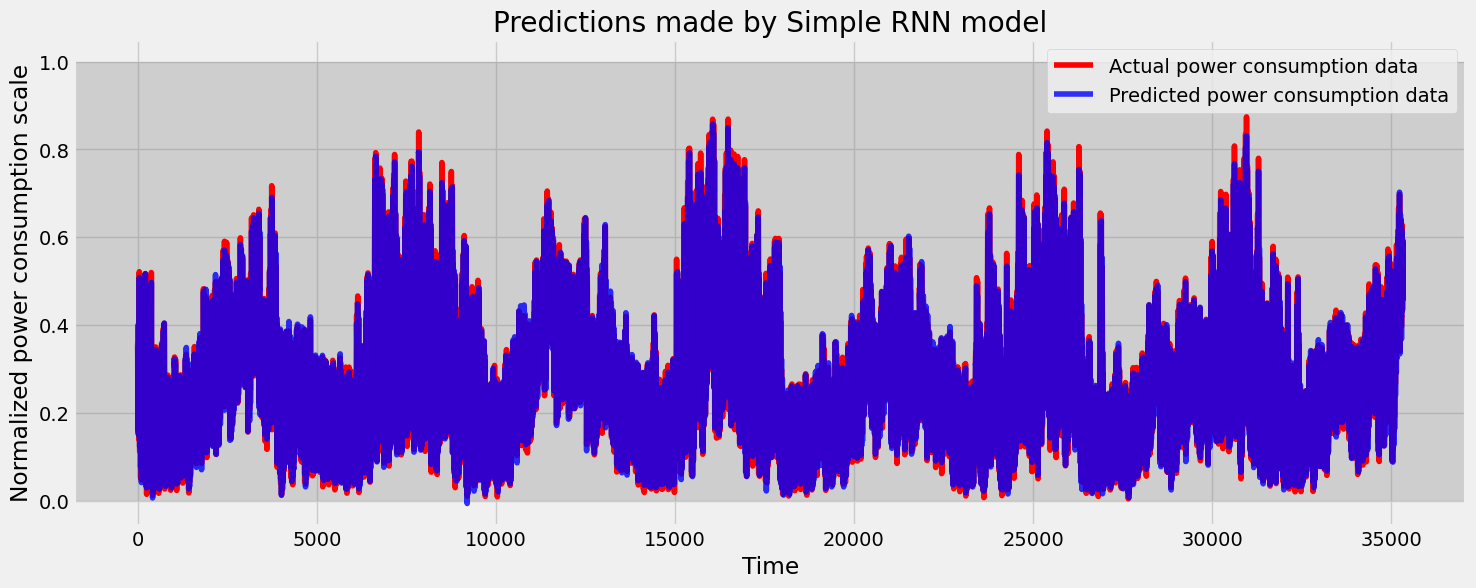

In [68]:
plt.figure(figsize=(16, 6))

# Plot actual and predicted power consumption data
plt.plot(y_test, color='red', label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.8, color='blue', label='Predicted power consumption data')

# Add a shaded region for better visualization of scale
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

# Add title and labels
plt.title("Predictions made by Simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')

# Add legend
plt.legend()
# Show plot
plt.show()

# 6. Building LSTM model


In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def create_lstm_model(input_shape):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=64, activation="tanh", return_sequences=True, input_shape=input_shape))
    lstm_model.add(Dropout(0.3))
    
    lstm_model.add(LSTM(units=64, activation="tanh", return_sequences=True))
    lstm_model.add(Dropout(0.3))
    
    lstm_model.add(LSTM(units=64, activation="tanh", return_sequences=False))
    lstm_model.add(Dropout(0.3))
    
    lstm_model.add(Dense(units=1))
    
    return lstm_model

# Define input shape based on X_train
input_shape = (X_train.shape[1], 1)

# Create LSTM model
lstm_model = create_lstm_model(input_shape)

# Display model summary
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [70]:
from keras.optimizers import Adam

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile LSTM model
lstm_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Define hyperparameters
epochs = 15
batch_size = 1024

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/15
97/97 [==============================] - 24s 222ms/step - loss: 0.0215 - val_loss: 0.0144
Epoch 2/15
97/97 [==============================] - 21s 221ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 3/15
97/97 [==============================] - 21s 212ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 4/15
97/97 [==============================] - 21s 214ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 5/15
97/97 [==============================] - 21s 218ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 6/15
97/97 [==============================] - 22s 225ms/step - loss: 0.0023 - val_loss: 8.6976e-04
Epoch 7/15
97/97 [==============================] - 21s 220ms/step - loss: 0.0020 - val_loss: 7.4159e-04
Epoch 8/15
97/97 [==============================] - 22s 222ms/step - loss: 0.0018 - val_loss: 6.9158e-04
Epoch 9/15
97/97 [==============================] - 22s 224ms/step - loss: 0.0017 - val_loss: 6.2889e-04
Epoch 10/15
97/97 [==============================] - 21s 220ms/step - loss:

In [72]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions using the RNN model
lstm_predictions = lstm_model.predict(X_test)

# Calculate R2 score
lstm_r2_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model =", lstm_r2_score)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
print("RMSE of LSTM model =", lstm_rmse)


1105/1105 [==============================] - 6s 5ms/step
R2 Score of LSTM model = 0.9773590723846485
RMSE of LSTM model = 0.022360651716013057


In [73]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions).flatten()

# Ensure lengths match
y_test_inverse = y_test_inverse[:len(last_6169_index_dates)]
lstm_predictions_inverse = lstm_predictions_inverse[:len(last_6169_index_dates)]

# Create DataFrame with aligned data
results_LSTM = pd.DataFrame({"Date": last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})

# Print the DataFrame
print(results_LSTM)

                    Date   Actual     Predicted
0    2017-02-13 23:00:00  34054.0  33628.285156
1    2017-02-14 00:00:00  34397.0  33047.105469
2    2017-02-12 01:00:00  33789.0  33326.753906
3    2017-02-12 02:00:00  31458.0  32451.425781
4    2017-02-12 03:00:00  28835.0  29885.673828
...                  ...      ...           ...
6164 2018-01-01 20:00:00  35571.0  35907.664062
6165 2018-01-01 21:00:00  35927.0  36376.863281
6166 2018-01-01 22:00:00  36028.0  36340.898438
6167 2018-01-01 23:00:00  35952.0  35843.261719
6168 2018-01-02 00:00:00  36887.0  35109.804688

[6169 rows x 3 columns]


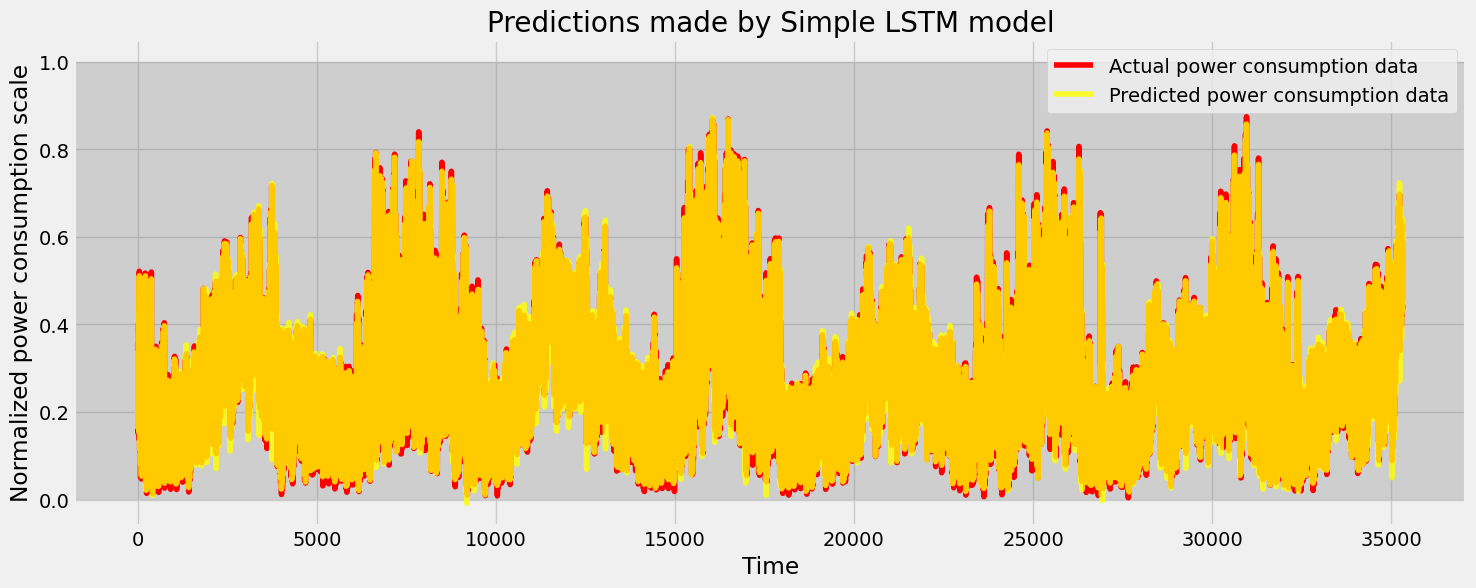

In [74]:
plt.figure(figsize=(16, 6))

# Plot actual and predicted power consumption data
plt.plot(y_test, color='red', label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.8, color='yellow', label='Predicted power consumption data')

# Add a shaded region for better visualization of scale
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

# Add title and labels
plt.title("Predictions made by Simple LSTM model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')

# Add legend
plt.legend()
# Show plot
plt.show()

# 6. Compare Predictions

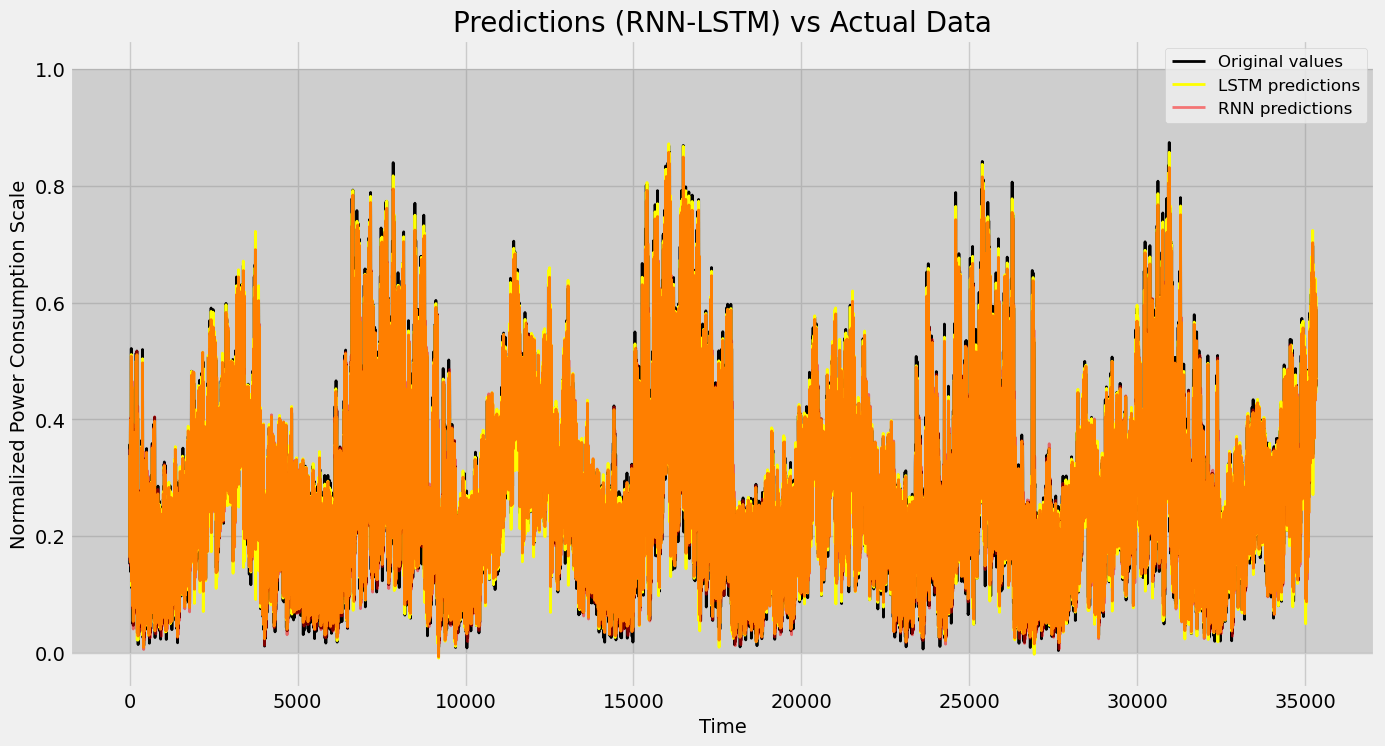

In [83]:
import matplotlib.pyplot as plt

# Define figure size and create the plot
plt.figure(figsize=(15, 8))

# Plot original values, LSTM predictions, and RNN predictions
plt.plot(y_test, color="black", linewidth=2, label="Original values")
plt.plot(lstm_predictions, color="yellow", linewidth=2, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, color="red", linewidth=2, label="RNN predictions")

# Add shaded region for better visualization of scale
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)  

# Add legend, title, and adjust font size
plt.legend(fontsize=12)
plt.title("Predictions (RNN-LSTM) vs Actual Data", fontsize=20)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Normalized Power Consumption Scale", fontsize=14)

# Show plot
plt.show()

# The End